In [25]:
# Importing necessary libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

# Importing libraries necessary for Model Building and Training
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
data = pd.read_csv('/content/spam_ham_dataset.csv')
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [5]:
data.shape

(5171, 4)

In [6]:
data.columns

Index(['Unnamed: 0', 'label', 'text', 'label_num'], dtype='object')

In [7]:
data.drop(['Unnamed: 0', 'label'], axis=1, inplace=True)

In [8]:
data.rename(columns={'label_num': 'spam'}, inplace=True)

In [9]:
data.shape

(5171, 2)

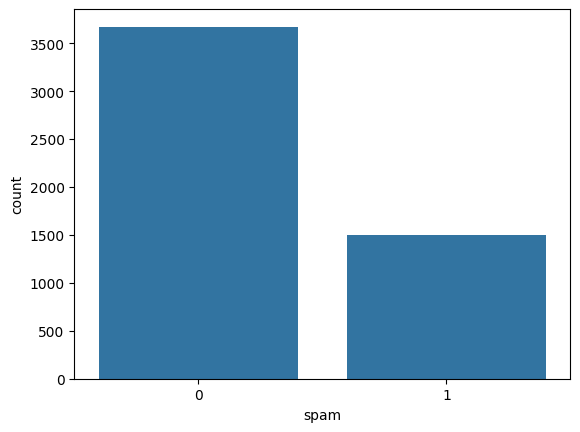

In [10]:
sns.countplot(x='spam', data=data)
plt.show()

In [11]:
data.head

<bound method NDFrame.head of                                                    text  spam
0     Subject: enron methanol ; meter # : 988291\r\n...     0
1     Subject: hpl nom for january 9 , 2001\r\n( see...     0
2     Subject: neon retreat\r\nho ho ho , we ' re ar...     0
3     Subject: photoshop , windows , office . cheap ...     1
4     Subject: re : indian springs\r\nthis deal is t...     0
...                                                 ...   ...
5166  Subject: put the 10 on the ft\r\nthe transport...     0
5167  Subject: 3 / 4 / 2000 and following noms\r\nhp...     0
5168  Subject: calpine daily gas nomination\r\n>\r\n...     0
5169  Subject: industrial worksheets for august 2000...     0
5170  Subject: important online banking alert\r\ndea...     1

[5171 rows x 2 columns]>

Text(0.5, 0, 'Message types')

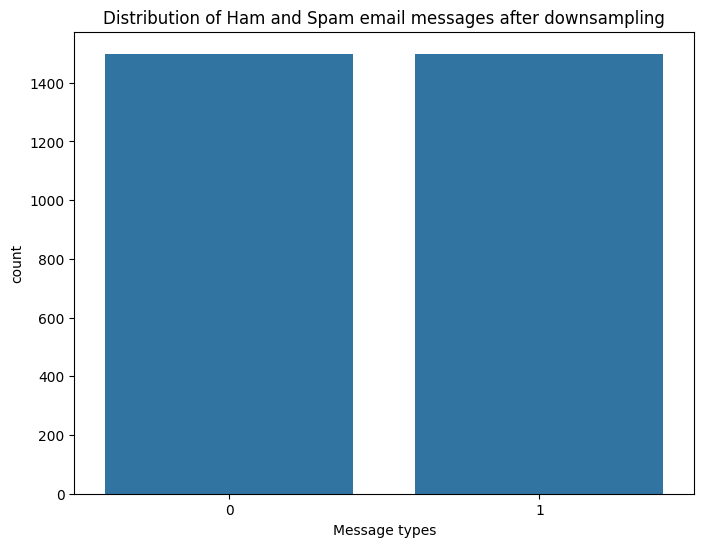

In [12]:
# Downsampling to balance the dataset
ham_msg = data[data.spam == 0]
spam_msg = data[data.spam == 1]
ham_msg = ham_msg.sample(n=len(spam_msg),
                         random_state=42)

# Plotting the counts of down sampled dataset
balanced_data = ham_msg.append(spam_msg)\
    .reset_index(drop=True)
plt.figure(figsize=(8, 6))
sns.countplot(data = balanced_data, x='spam')
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')

In [13]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data.head()

,text,spam
0,: conoco - big cowboy\r\ndarren :\r\ni ' m not...,0
1,: feb 01 prod : sale to teco gas processing\r\...,0
2,": california energy crisis\r\ncalifornia  , s...",0
3,: re : nom / actual volume for april 23 rd\r\n...,0
4,: eastrans nomination changes effective 8 / 2 ...,0


In [14]:
#removing stopwords
def remove_stopwords(text):
    stop_words = stopwords.words('english')

    imp_words = []

    # Storing the important words
    for word in str(text).split():
        word = word.lower()

        if word not in stop_words:
            imp_words.append(word)

    output = " ".join(imp_words)

    return output


balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

,text,spam
0,": conoco - big cowboy darren : ' sure help , '...",0
1,: feb 01 prod : sale teco gas processing sale ...,0
2,": california energy crisis california  , powe...",0
3,": : nom / actual volume april 23 rd agree "" ei...",0
4,: eastrans nomination changes effective 8 / 2 ...,0


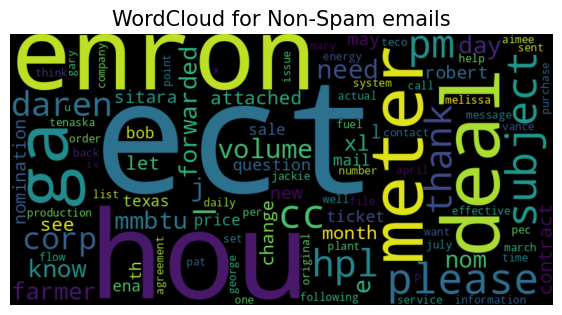

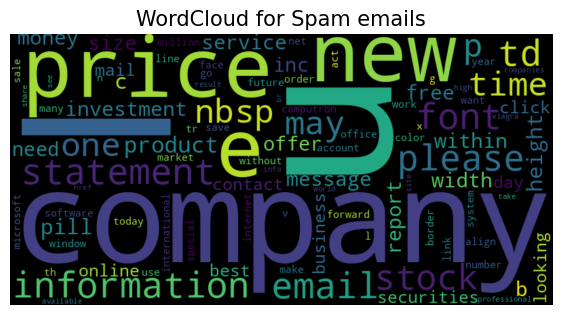

In [15]:
#wordcloud to develop a visual of the most frequent spam words
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])

    plt.figure(figsize=(7, 7))

    wc = WordCloud(background_color='black',
                   max_words=100,
                   width=800,
                   height=400,
                   collocations=False).generate(email_corpus)

    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} emails', fontsize=15)
    plt.axis('off')
    plt.show()

plot_word_cloud(balanced_data[balanced_data['spam'] == 0], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['spam'] == 1], typ='Spam')

In [16]:
#train test split
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['text'],balanced_data['spam'],test_size = 0.2,random_state = 42)

In [17]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences to have the same length
max_len = 100  # maximum sequence length
train_sequences = pad_sequences(train_sequences,maxlen=max_len, padding='post', truncating='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

In [19]:
# Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,output_dim=32, input_length=max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 32)           1274368   
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1278081 (4.88 MB)
Trainable params: 1278081 (4.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),metrics = ['accuracy'],optimizer = 'adam')

In [21]:
es = EarlyStopping(patience=3,monitor = 'val_accuracy',restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,monitor = 'val_loss',factor = 0.5,verbose = 0)

In [22]:
# Train the model
history = model.fit(train_sequences, train_Y,validation_data=(test_sequences, test_Y),
                    epochs=20,
                    batch_size=32,
                    callbacks = [lr, es]
                   )

Epoch 1/20
75/75 [==============================] - 10s 71ms/step - loss: 0.6848 - accuracy: 0.5717 - val_loss: 0.5964 - val_accuracy: 0.7317 - lr: 0.0010
Epoch 2/20
75/75 [==============================] - 5s 70ms/step - loss: 0.2500 - accuracy: 0.9450 - val_loss: 0.1611 - val_accuracy: 0.9617 - lr: 0.0010
Epoch 3/20
75/75 [==============================] - 5s 64ms/step - loss: 0.2076 - accuracy: 0.9441 - val_loss: 0.2509 - val_accuracy: 0.9133 - lr: 0.0010
Epoch 4/20
75/75 [==============================] - 5s 63ms/step - loss: 0.2240 - accuracy: 0.9270 - val_loss: 0.1987 - val_accuracy: 0.9350 - lr: 0.0010
Epoch 5/20
75/75 [==============================] - 6s 78ms/step - loss: 0.1897 - accuracy: 0.9420 - val_loss: 0.1573 - val_accuracy: 0.9600 - lr: 5.0000e-04


In [23]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

19/19 [==============================] - 0s 16ms/step - loss: 0.1611 - accuracy: 0.9617
Test Loss : 0.1610736846923828
Test Accuracy : 0.9616666436195374


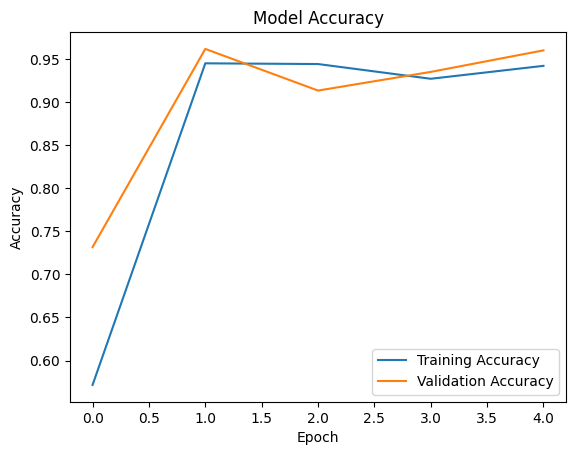

In [24]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()